# Project Description

Please find all the details in this video [here](https://www.youtube.com/watch?v=vQ91cJOEz-4). The original slides are stored [here](https://quip.com/3ZqOA7qZfS78).

# Load Data and Pre-process

## Functions for Loading & Pre-processing

In [ ]:
''' Imports for loading stuff in .p form from Google Drive into arrays.'''
import os
import pickle
import numpy as np

def load_input_data(storage_folder, which_kind):
	"""
	Unpickle the data stored in the folder. The name of the measurement data
	inside the folder is considered as 'data_arrays_which_kind-data-' + standards.
	The measurement data for each standard is returned in a list.	Standard must be
  a list of Strings. The data is loaded in the order of the standards.
	"""

  # Declare variables in this scope.
	x_data = None
	data_file = None
	
  # Decide which input data to load.
	if which_kind == 'iq':
		data_file = 'data_iq.p'
	elif which_kind == 'fft':
		data_file = 'data_fft.p'
	else:
		raise ValueError('Parameter which_kind must be "iq" for IQ-data or "fft" for FFT-data.')

  # Data is loaded in the form of a byte stream for pickle and the 'latin-1'
  # encoding is used to read the data initially generated for Python 2.7

  # Load input data (x). 
	data_path = os.path.join(storage_folder, data_file)
	with open(data_path, mode='rb') as storage:
	  x_data = pickle.load(storage, encoding='latin-1')
	
	return x_data

def load_output_data(storage_folder):
	"""
	Unpickle the label data stored in the folder. The label data is considered as 
  'labels-data-' + standards.	The label data for each standard is returned in a 
  list of integers. The labels are loaded in the order of the standards.
	"""

  # Declare variables in this scope.
	y_data = None

  # Data is loaded in the form of a byte stream for pickle and the 'latin-1'
  # encoding is used to read the data initially generated for Python 2.7
  
  # Load output data/labels (y).
	label_file = 'labels.p'
	label_path = os.path.join(storage_folder, label_file)
	with open(label_path, mode='rb') as storage:
		y_data = pickle.load(storage, encoding='latin-1')

	return y_data

def normalize_data(x):
	"""
  x is a numpy array which should be normalized. Normalizes the training data
  to have a train_mean of 0 and a standard deviation of 1. Removes bias in the 
  data for better training. Returns the normalized data in the same format.
	"""
 
  # Subtract mean and divide by standard deviation to normalize.
	flat_x = x.flatten()
	return ((x - np.mean(flat_x))/np.std(flat_x))
 
def scale_data(x):
	"""
  x is a numpy array which should be scaled. Scales the data to have a minimum
  value of 0 and maximum value of 1. Removes bias in the data for better 
  training. Returns the normalized data in the same format.
	"""
 
  # Subtract mean and divide by standard deviation to normalize.
	flat_x = x.flatten()
	return ((x - np.min(flat_x))/(np.max(flat_x) - np.min(flat_x)))


## Load the Data

In [ ]:
from google.colab import drive
drive.mount('/gdrive/')
!ls /gdrive
folder = '/gdrive/MyDrive/Wireless_Interference_Identification_Dataset/labeled_data'
folder2 = '/gdrive/MyDrive/Wireless_Interference_Identification_Dataset2'

Mounted at /gdrive/
MyDrive


In [ ]:
# Load 'fft' data.
x_data_fft_data = load_input_data(folder2, 'fft')

# Load 'iq' data.
x_data_iq_data = load_input_data(folder, 'iq')

# Load the labels.
y_labels_data = load_output_data(folder)

## Format of Data

The data structure is a 5-dimensional tensor of the below structure.

*15 x 21 x 715 x 128 x 2 - Tensor*
*Label x SNR x Snapshot x Samples x IQ Data*


**Description of Snapshots:**

Each snapshot has 128 complex samples. The real and imaginary component are
represented by the last dimension.

'iq'- Time series of IQ samples

'fft'- Frequency samples of FFT of IQ series 


**Label:**

0..9: Bluetooth signal at center frequency of 2422 MHz + Label * 1 MHz representing channels 20-29 respectively.

10..12: WiFi (802.11b/g) signal at center frequency of 2422 MHz + (Label - 10) * 5 MHz representing channels 3, 4, 5 respectively.

13..14: Zigbee (802.15.4) signal at center frequency of 2425 MHz + (Label - 13) * 5 MHz
representing channels 15 and 16.

The frequency offset is necessary because different offsets expose different
channels of the signals as in the below.


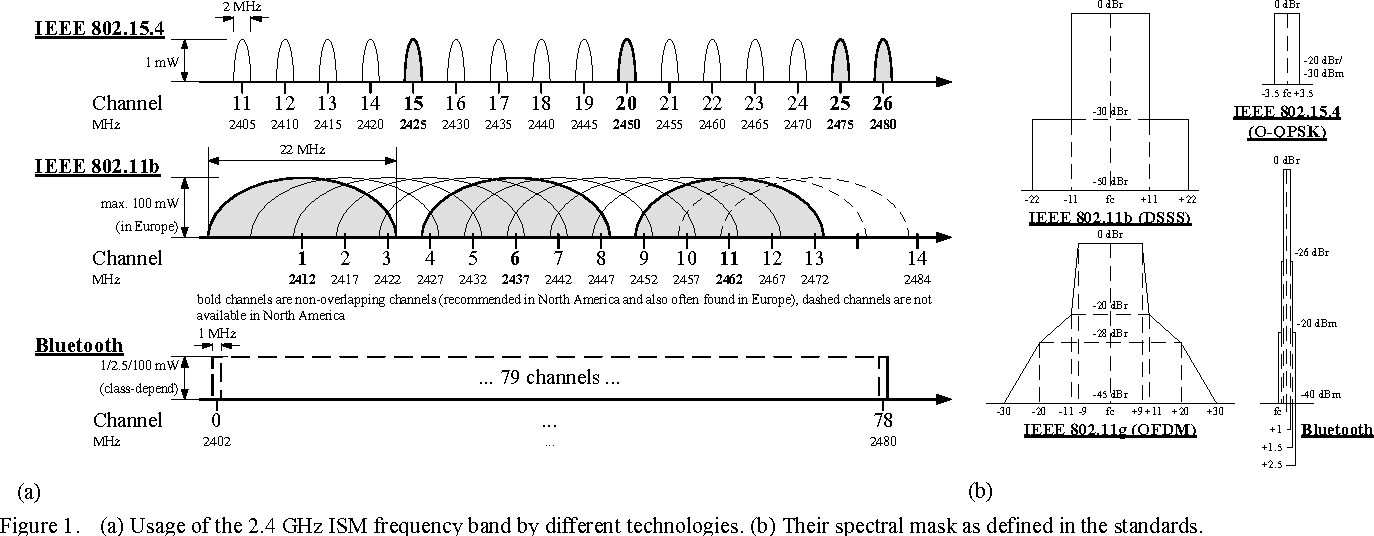

**SNR:**

0..20: SNR between -20 dB...20 dB with the step size of 2 dB, (e.g. index 6 referres to SNR of -8 dB).

Stronger SNRs represent easier to identify stronger signals but we train the
neural network on signals of all SNR.

**Snapshot:**

0..714: Number of the snapshots per Label

**Samples:**

0..127: Sample number per snapshot

**iq:**

0: In-Phase

1: Quadrature

## Flatten the Data

We flatten the data as to get the data in the below form.

1. The first dimension represents the snapshot number. There would be *Tensor
Label x SNR x Snapshot* = 15015 snapshots per technology.
2. The second dimension would be along the different samples of the snapshot. 
3. The last dimension would represent the IQ signals.

In [ ]:
x_dim = x_data_fft_data.shape
total_num_snapshots = x_dim[0]*x_dim[1]*x_dim[2]
num_snapshots_per_tech = x_dim[1]*x_dim[2]
num_tech = x_dim[0]
num_samples = x_dim[3]
print(num_snapshots_per_tech)

15015


In [ ]:
y_labels = y_labels_data.flatten()
x_data_fft = np.reshape(x_data_fft_data, (total_num_snapshots, x_dim[3], x_dim[4]))
x_data_iq = np.reshape(x_data_iq_data, (total_num_snapshots, x_dim[3], x_dim[4]))

## Visualize the Data

We view sample series for each technology in the below forms.

1. Magnitude of FFT data
2. Magnitude of FFT data in dB
3. Phase of FFT data
4. Real component of FFT data
5. Imaginary component of FFT data
6. Magnitude of time series
7. Magnitude of time series in dB
8. Phase of time series
9. Real component time series
10. Imaginary component time series

Additional methods for converting such complex number series into images using Gramian Angular Field (GAF), Markov Transition Field (MTF) etc. for ease of processing with CNNs are available in the [PYTS](https://) package but I don't look into that yet. Conversion to spectrogram, spectral coherence function etc. requires many more snapshots and they need to be temporally related. Explicit energy detection or thresholding is something that could be tried but the NN layers should this by itself. Constellation plotting based on the IQ series is another option to obtain images.

In [ ]:
import matplotlib.pyplot as plt
titles = ['Bluetooth CH20', 'Bluetooth CH21', 'Bluetooth CH22', 'Bluetooth CH23', 'Bluetooth CH24', 'Bluetooth CH25', 'Bluetooth CH26', 'Bluetooth CH27', 'Bluetooth CH28', 'Bluetooth CH29', 'WiFi CH3', 'WiFi CH4', 'WiFi CH5', 'ZigBee CH15', 'ZigBee CH16']

iq_view_data = x_data_iq[::num_snapshots_per_tech][:][:]
iq_view_data_complex = np.reshape(iq_view_data.flatten()[::2] + 1j*iq_view_data.flatten()[1::2], (num_tech, num_samples))
iq_view_data_real = np.reshape(iq_view_data.flatten()[::2], (num_tech, num_samples))
iq_view_data_imag = np.reshape(iq_view_data.flatten()[1::2], (num_tech, num_samples))
iq_view_data_abs = np.absolute(iq_view_data_complex)
iq_view_data_abs_dB = 20*np.log10(np.absolute(iq_view_data_complex))
iq_view_data_angle = np.angle(iq_view_data_complex)

fft_view_data = x_data_fft[::num_snapshots_per_tech][:][:]
fft_view_data_complex = np.reshape(fft_view_data.flatten()[::2] + 1j*fft_view_data.flatten()[1::2], (num_tech, num_samples))
fft_view_data_real = np.reshape(fft_view_data.flatten()[::2], (num_tech, num_samples))
fft_view_data_imag = np.reshape(fft_view_data.flatten()[1::2], (num_tech, num_samples))
fft_view_data_abs = np.absolute(fft_view_data_complex)
fft_view_data_abs_dB = 20*np.log10(np.absolute(fft_view_data_complex))
fft_view_data_angle = np.angle(fft_view_data_complex)

### 1. Magnitude of FFT Data

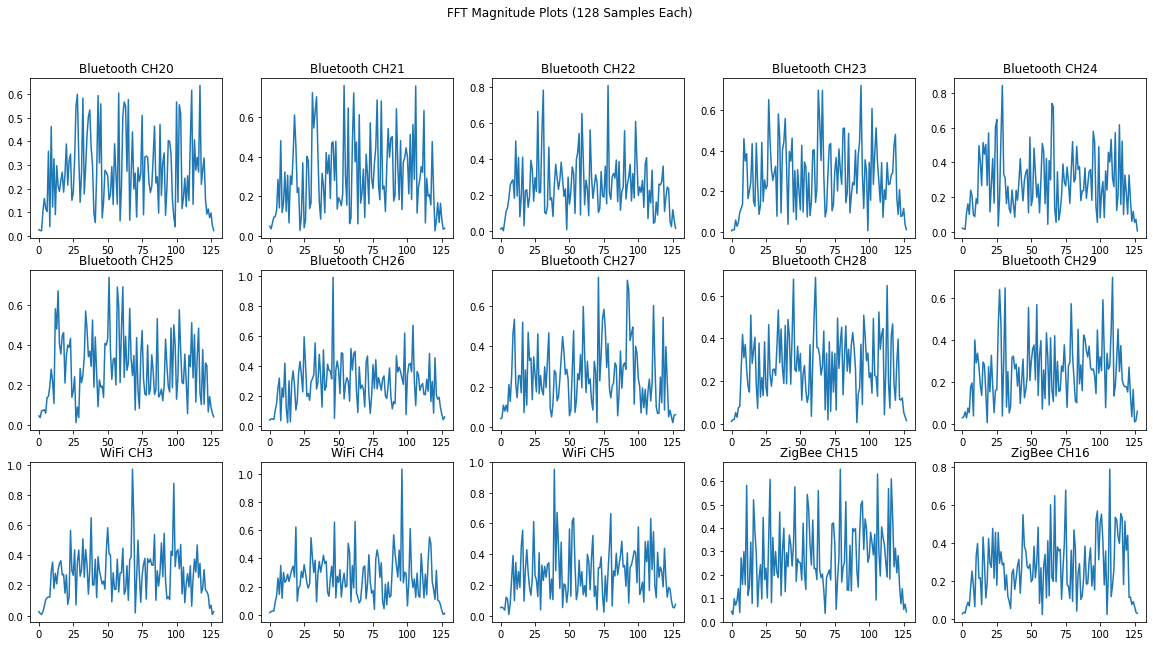

In [ ]:
fig, ax = plt.subplots(3, 5)
fig.suptitle('FFT Magnitude Plots (128 Samples Each)')
fig.set_figheight(10)
fig.set_figwidth(20)

for i in range(num_tech):
  ax[i//5][i%5].plot(fft_view_data_abs[i])
  ax[i//5][i%5].set_title(titles[i])

### 2. Magnitude of FFT Data in dB

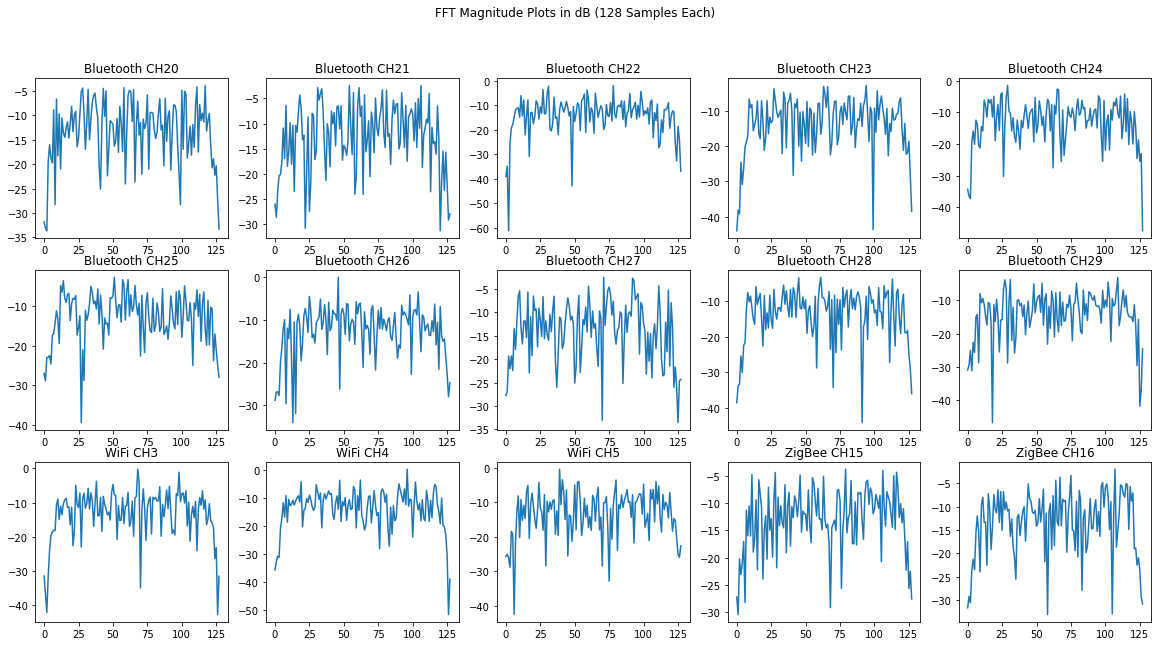

In [ ]:
fig, ax = plt.subplots(3, 5)
fig.suptitle('FFT Magnitude Plots in dB (128 Samples Each)')
fig.set_figheight(10)
fig.set_figwidth(20)

for i in range(num_tech):
  ax[i//5][i%5].plot(fft_view_data_abs_dB[i])
  ax[i//5][i%5].set_title(titles[i])

### 3. Phase of FFT Data

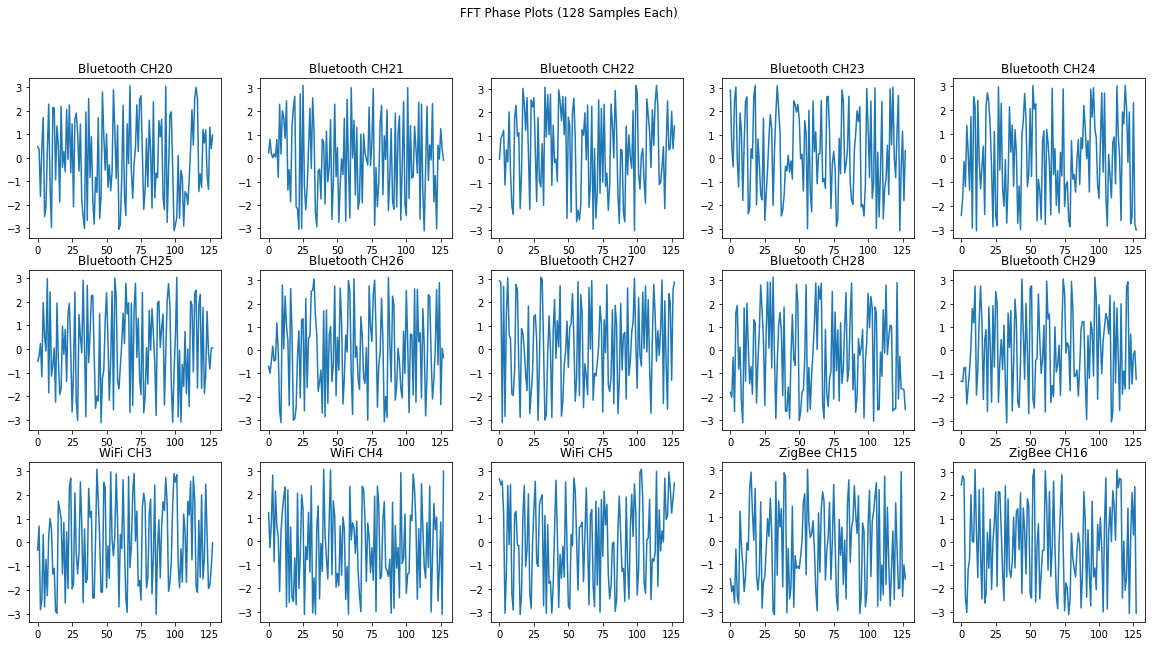

In [ ]:
fig, ax = plt.subplots(3, 5)
fig.suptitle('FFT Phase Plots (128 Samples Each)')
fig.set_figheight(10)
fig.set_figwidth(20)

for i in range(num_tech):
  ax[i//5][i%5].plot(fft_view_data_angle[i])
  ax[i//5][i%5].set_title(titles[i])

### 4. Real Component of FFT Data

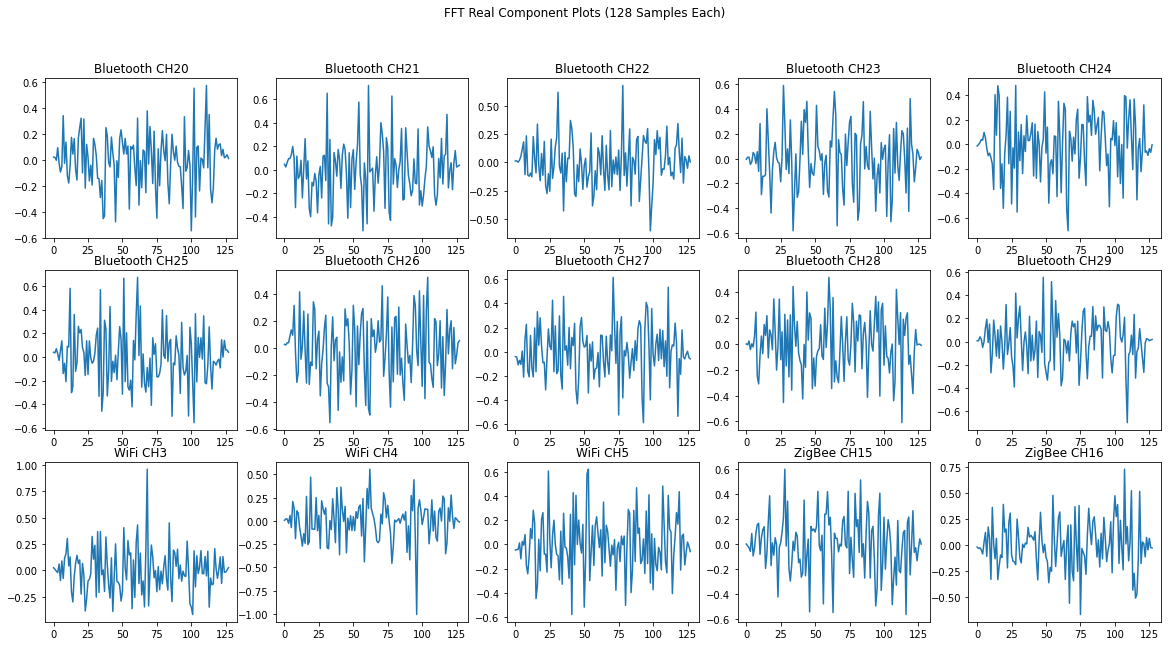

In [ ]:
fig, ax = plt.subplots(3, 5)
fig.suptitle('FFT Real Component Plots (128 Samples Each)')
fig.set_figheight(10)
fig.set_figwidth(20)

for i in range(num_tech):
  ax[i//5][i%5].plot(fft_view_data_real[i])
  ax[i//5][i%5].set_title(titles[i])

### 5. Imaginary Component of FFT Data

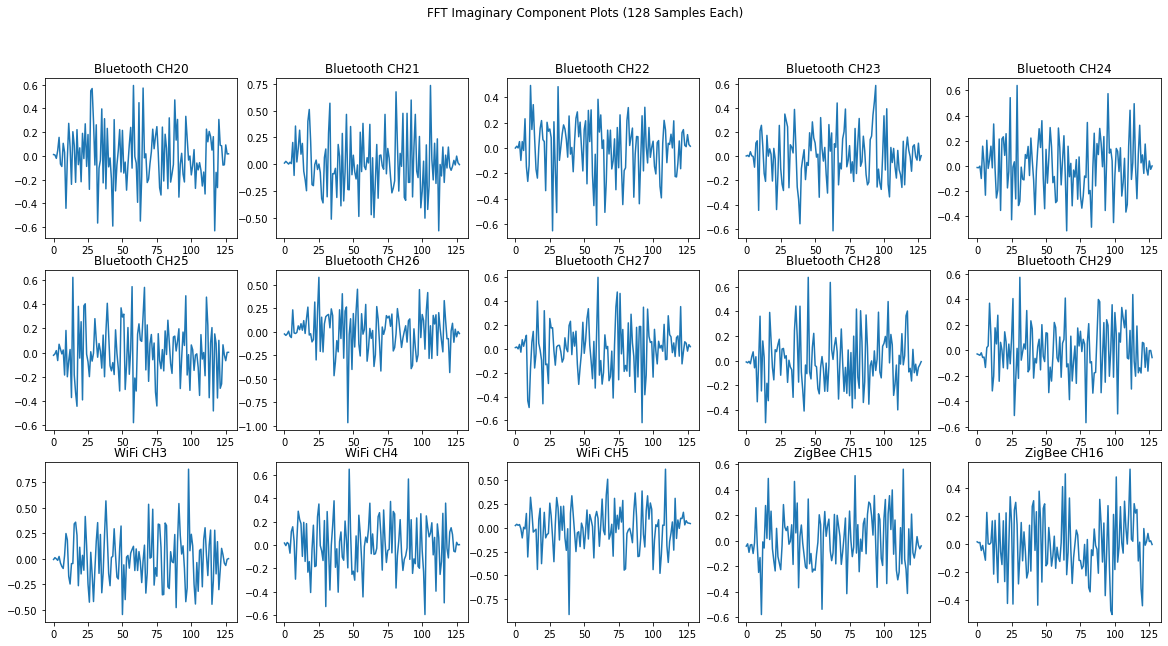

In [ ]:
fig, ax = plt.subplots(3, 5)
fig.suptitle('FFT Imaginary Component Plots (128 Samples Each)')
fig.set_figheight(10)
fig.set_figwidth(20)

for i in range(num_tech):
  ax[i//5][i%5].plot(fft_view_data_imag[i])
  ax[i//5][i%5].set_title(titles[i])

### 6. Magnitude of IQ Data

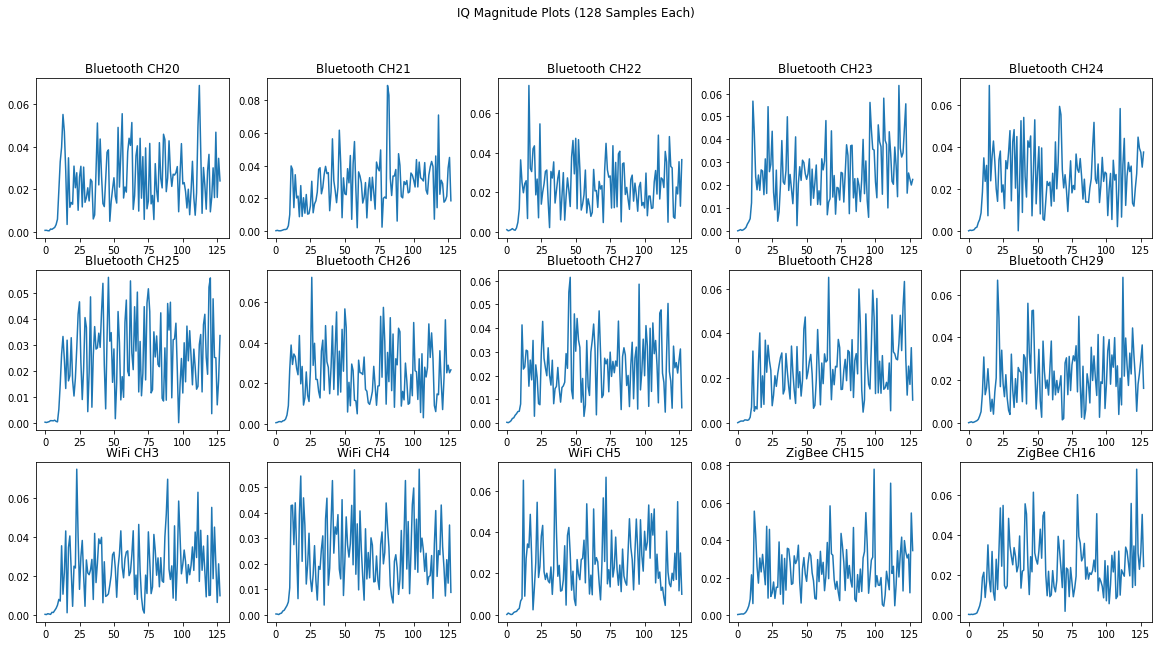

In [ ]:
fig, ax = plt.subplots(3, 5)
fig.suptitle('IQ Magnitude Plots (128 Samples Each)')
fig.set_figheight(10)
fig.set_figwidth(20)

for i in range(num_tech):
  ax[i//5][i%5].plot(iq_view_data_abs[i])
  ax[i//5][i%5].set_title(titles[i])

### 7. Magnitude of IQ Data in dB

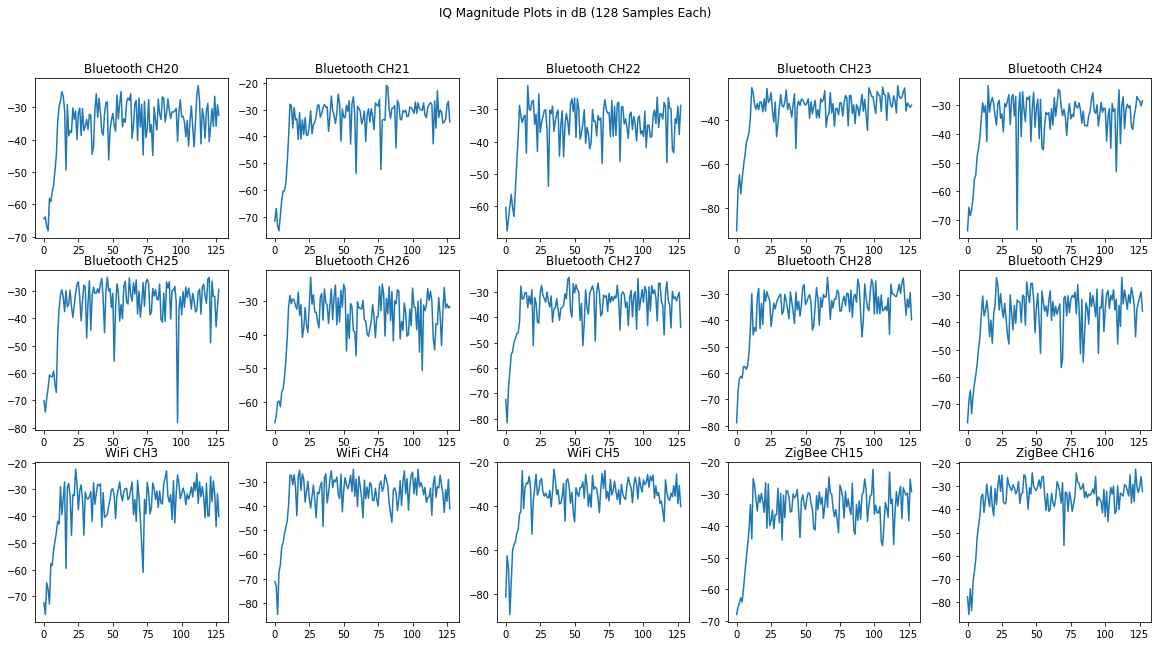

In [ ]:
fig, ax = plt.subplots(3, 5)
fig.suptitle('IQ Magnitude Plots in dB (128 Samples Each)')
fig.set_figheight(10)
fig.set_figwidth(20)

for i in range(num_tech):
  ax[i//5][i%5].plot(iq_view_data_abs_dB[i])
  ax[i//5][i%5].set_title(titles[i])

### 8. Phase of IQ Data

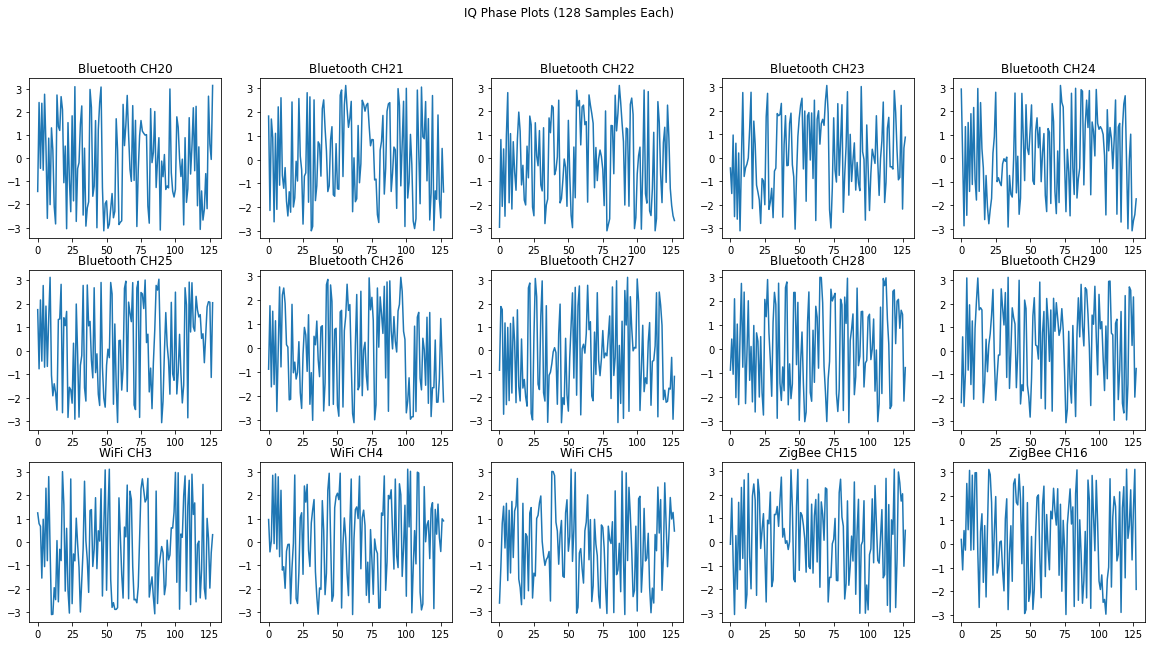

In [ ]:
fig, ax = plt.subplots(3, 5)
fig.suptitle('IQ Phase Plots (128 Samples Each)')
fig.set_figheight(10)
fig.set_figwidth(20)

for i in range(num_tech):
  ax[i//5][i%5].plot(iq_view_data_angle[i])
  ax[i//5][i%5].set_title(titles[i])

### 9. Real Component of IQ Data

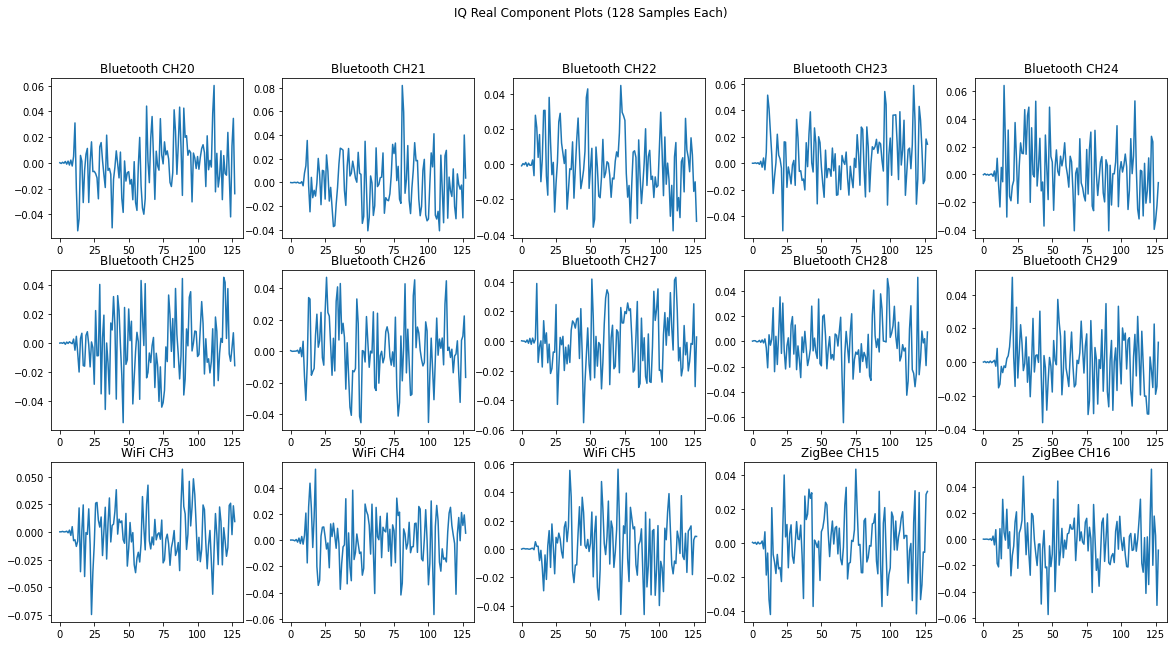

In [ ]:
fig, ax = plt.subplots(3, 5)
fig.suptitle('IQ Real Component Plots (128 Samples Each)')
fig.set_figheight(10)
fig.set_figwidth(20)

for i in range(num_tech):
  ax[i//5][i%5].plot(iq_view_data_real[i])
  ax[i//5][i%5].set_title(titles[i])

### 10. Imaginary Component of IQ Data

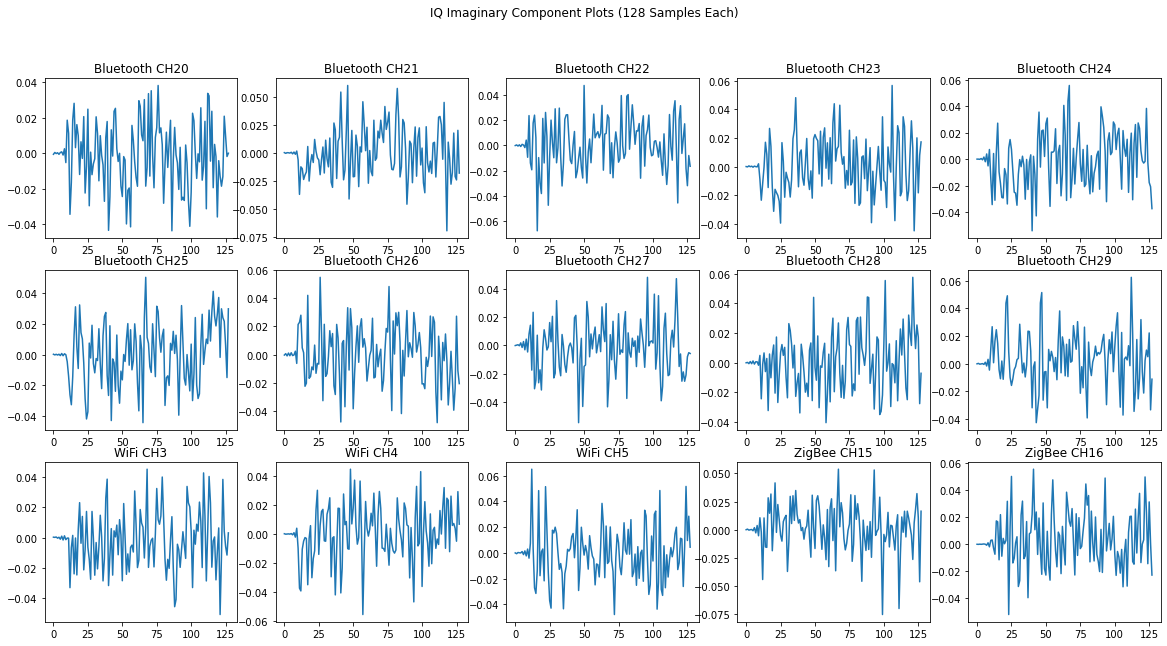

In [ ]:
fig, ax = plt.subplots(3, 5)
fig.suptitle('IQ Imaginary Component Plots (128 Samples Each)')
fig.set_figheight(10)
fig.set_figwidth(20)

for i in range(num_tech):
  ax[i//5][i%5].plot(iq_view_data_imag[i])
  ax[i//5][i%5].set_title(titles[i])

## Preprocess Data

We apply the same transformations we applied to the 15 data samples for viewing in addition to creating an additional flat vector with alternating IQ samples. In addition, [data scaling](https://machinelearningmastery.com/how-to-improve-neural-network-stability-and-modeling-performance-with-data-scaling/) is applied to improve deep learning stability and performance.

Although I don't do an Exploratory Data Analysis here, from wireless communications theory the below hold.

1. For the IQ data, global scaling is used since all samples are indepedent. 
2. For the FFT data, binwise scaling is used since each bin's information is separate due to the transform. 
3. The real, imaginary and phase samples are assumed to be gaussian in nature implying the use of standard scaling. 
4. The min-max to 01 scaling is used for the magnitude data since they are positive in magnitude.

In addition the y_data corresponding to the labels needs to be converted to the one-hot encoding form for use with neural networks.

In [ ]:
# Global scalers for IQ.
iq_data_complex = np.reshape(x_data_iq.flatten()[::2] + 1j*x_data_iq.flatten()[1::2], (total_num_snapshots, num_samples))
iq_data_real = normalize_data(np.reshape(x_data_iq.flatten()[::2], (total_num_snapshots, num_samples)))
iq_data_imag = normalize_data(np.reshape(x_data_iq.flatten()[1::2], (total_num_snapshots, num_samples)))
iq_data_abs = scale_data(np.absolute(iq_data_complex))
iq_data_abs_dB = scale_data(np.log10(np.absolute(iq_data_complex)))
iq_data_angle = normalize_data(np.angle(iq_data_complex))
iq_data_flat = normalize_data(np.reshape(x_data_iq, (total_num_snapshots, num_samples*2)))
iq_data_2d = normalize_data(x_data_iq)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# Bin wise scalers for FFT data from sklearn
scaler_01 = MinMaxScaler(feature_range=(0,1))
scaler_std = StandardScaler()

fft_data_complex = np.reshape(x_data_fft.flatten()[::2] + 1j*x_data_fft.flatten()[1::2], (total_num_snapshots, num_samples))
fft_data_real = scaler_std.fit_transform(np.reshape(x_data_fft.flatten()[::2], (total_num_snapshots, num_samples)))
fft_data_imag = scaler_std.fit_transform(np.reshape(x_data_fft.flatten()[1::2], (total_num_snapshots, num_samples)))
fft_data_abs = scaler_01.fit_transform(np.absolute(fft_data_complex))
fft_data_abs_dB = scaler_01.fit_transform(np.log10(np.absolute(fft_data_complex)))
fft_data_angle = scaler_std.fit_transform(np.angle(fft_data_complex))
fft_data_flat = scaler_std.fit_transform(np.reshape(x_data_fft, (total_num_snapshots, num_samples*2)))
fft_data_2d = np.reshape(fft_data_flat, (total_num_snapshots, num_samples, 2))

In [ ]:
from keras.utils.np_utils import to_categorical

y_labels_one_hot = to_categorical(y_labels)

# FFT Data Classification




## Checking for Variance with K-fold Validation

I implement the neural networks in Keras here since I don't really need customizability to the extent offered by Torch and accuracy is the main metric here. I am mainly interested in which algorithm and network works best and my only metric to evaluate them is the accuracy.

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, LeakyReLU, Dropout, Conv2D, Flatten
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Define baseline model
def baseline_model():
	# Create model
	model = Sequential(
    [      
      Dense(num_tech, input_dim=num_samples, activation='softmax'),
    ]
  )
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

In [ ]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=50, batch_size=50, verbose=2)
kfold = KFold(n_splits=3, shuffle=True)
results = cross_val_score(estimator, fft_data_abs_dB, y_labels_one_hot, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Epoch 1/50
3003/3003 - 5s - loss: 2.0659 - accuracy: 0.5333
Epoch 2/50
3003/3003 - 3s - loss: 1.4161 - accuracy: 0.7286
Epoch 3/50
3003/3003 - 3s - loss: 1.1694 - accuracy: 0.7650
Epoch 4/50
3003/3003 - 2s - loss: 1.0367 - accuracy: 0.7837
Epoch 5/50


KeyboardInterrupt: ignored

The results of the 3-fold with the the FFT_data_abs_dB shows that the average accuracy is 84.68% with an average accuracy of 0.21%.

Since the variance accross the folds is so low with the illustrative 3-fold example and there are so many snapshots, for the sake of time in evaluating neural networks, I will only use a single test train split.  

The fft_data_flat and iq_data_flat each have 256 samples for each snapshot and needs be tried differently with a larger sized network. The same goes for the 2D data for both types which would need a convolutional neural network. Extensions to complex data may also be possible.

## Data Form Selection for Fully Connected Neural Networks  with Train-Test Split

Our aim is to select the best neural network and the best format for the data out of the 10 types I have described earlier or a combination of them. All these 10 data types have 128 samples for each snapshot and will be classified together.

In [ ]:
from sklearn.model_selection import train_test_split
import math

X_train = np.zeros((10, math.floor(0.75*total_num_snapshots), num_samples))
X_test = np.zeros((10, math.ceil(0.25*total_num_snapshots), num_samples))
Y_train = np.zeros((10, math.floor(0.75*total_num_snapshots), num_tech))
Y_test = np.zeros((10, math.ceil(0.25*total_num_snapshots), num_tech))

X_train[0], X_test[0], Y_train[0], Y_test[0] = train_test_split(fft_data_abs_dB, y_labels_one_hot, test_size=0.25)
X_train[1], X_test[1], Y_train[1], Y_test[1] = train_test_split(fft_data_abs, y_labels_one_hot, test_size=0.25)
X_train[2], X_test[2], Y_train[2], Y_test[2] = train_test_split(fft_data_real, y_labels_one_hot, test_size=0.25)
X_train[3], X_test[3], Y_train[3], Y_test[3] = train_test_split(fft_data_imag, y_labels_one_hot, test_size=0.25)
X_train[4], X_test[4], Y_train[4], Y_test[4] = train_test_split(fft_data_angle, y_labels_one_hot, test_size=0.25)
X_train[5], X_test[5], Y_train[5], Y_test[5] = train_test_split(iq_data_abs_dB, y_labels_one_hot, test_size=0.25)
X_train[6], X_test[6], Y_train[6], Y_test[6] = train_test_split(iq_data_abs, y_labels_one_hot, test_size=0.25)
X_train[7], X_test[7], Y_train[7], Y_test[7] = train_test_split(iq_data_real, y_labels_one_hot, test_size=0.25)
X_train[8], X_test[8], Y_train[8], Y_test[8] = train_test_split(iq_data_imag, y_labels_one_hot, test_size=0.25)
X_train[9], X_test[9], Y_train[9], Y_test[9] = train_test_split(iq_data_angle, y_labels_one_hot, test_size=0.25)

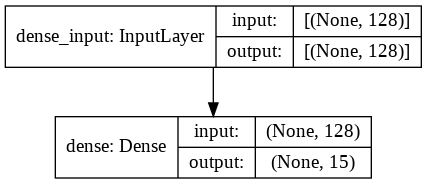

In [ ]:
from keras.utils import plot_model
bs_model = baseline_model()
plot_model(bs_model, show_shapes=True)

In [ ]:
scores_bs = np.zeros(10)

for i in range(10):
  bs_model.fit(X_train[i], Y_train[i], epochs=500, batch_size=50, verbose=2)
  score = bs_model.evaluate(X_test[i], Y_test[i], verbose=0)
  scores_bs[i] = score[1]*100

Epoch 1/500
3379/3379 - 8s - loss: 2.0110 - accuracy: 0.5595
Epoch 2/500
3379/3379 - 5s - loss: 1.3514 - accuracy: 0.7385
Epoch 3/500
3379/3379 - 5s - loss: 1.1173 - accuracy: 0.7717
Epoch 4/500


KeyboardInterrupt: ignored

In [ ]:
scores_bs

array([85.90050936, 88.90368938, 20.58891505, 20.20352781,  7.7841118 ,
        9.85312685,  7.63670579, 16.48462862, 16.04063511, 14.31260705])

On trying the base line model with the 10 different data types we find that the 'FFT_data_abs' does the best. Hence we continue with experiments based only on this for fully connected neural networks.

The accuracies noted for each of the data forms all representing the same information are as below.

1. FFT Data Magnitude in dB- 85.90050936 %
2. FFT Data Magnitude- 88.90368938%
3. Real Part of FFT Data- 20.58891505%
4. Imaginary Part of FFT Data- 20.20352781%
5. Phase Part of FFT Data- 7.7841118%
6. IQ Data Magnitude in dB- 9.85312685%
7. IQ Data Magnitude- 7.63670579%
8. Real Part of IQ Data- 16.48462862%
9. Imaginary Part of IQ Data- 16.04063511%
10. Phase Part of IQ Data- 14.31260705%

We make the below observations as well.

a. The best classification is based on the FFT magnitude since most of the wireless technology features are evidenced by the frequency bins. A linear scale works better than the log scale implying a flat spectrum.

b. The first thing we notice is that the accuracies for the 5 IQ time series are lower with the fully connected neural networks we use. These are better classified with LSTMs and RNNs and not fully connected networks.

c. The accuracy based on the IQ magnitude and phase part of the FFT data is almost 1/15 implying that they are uniform with time and frequency respectively.

d. The real and imaginary parts of both the IQ & FFT data lead to low accuracies implying that they are not sufficient information for classification by themselves. However, the real and imaginary parts of the FFT data seems to have more information. The phase part of IQ data does not have as much information as well.

Also, all these indicate that when a 2D convolutional neural network is to be applied, the FFT data in the IQ form or phase/magnitude form would work best over IQ time series data.

## Fully Connected Neural Networks for FFT Magnitude

I devise the below models with hidden layers for testing with the FFT Data Magnitude only.

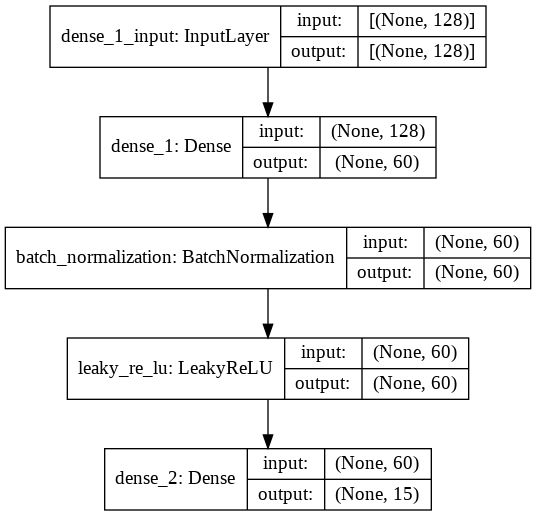

In [ ]:
# Define model with one hidden layer
def hidden_model():
	# Create model
	model = Sequential(
    [      
      Dense(60, input_dim=num_samples),
      BatchNormalization(),
      LeakyReLU(),
      Dense(num_tech, activation='softmax'),
    ]
  )
  # Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

h1_model = hidden_model()
plot_model(h1_model, show_shapes=True)

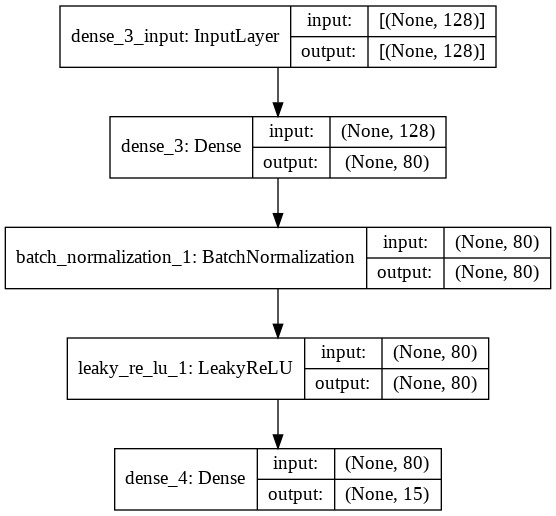

In [ ]:
# Define model with one hidden layer
def hidden_model2():
	# Create model
	model = Sequential(
    [      
      Dense(80, input_dim=num_samples),
      BatchNormalization(),
      LeakyReLU(),
      Dense(num_tech, activation='softmax'),
    ]
  )
  # Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

h2_model = hidden_model2()
plot_model(h2_model, show_shapes=True)

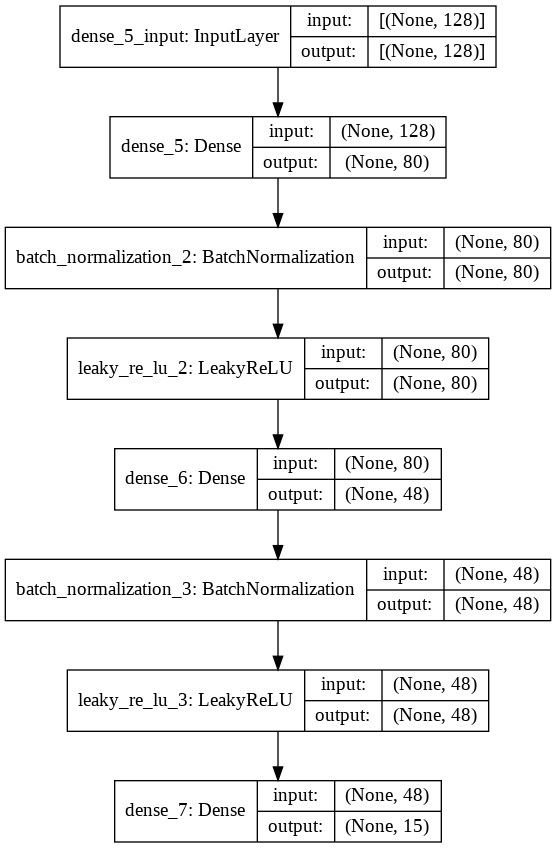

In [ ]:
# Define model with one hidden layer
def hidden_model3():
	# Create model
	model = Sequential(
    [      
      Dense(80, input_dim=num_samples),
      BatchNormalization(),
      LeakyReLU(),
      Dense(48),
      BatchNormalization(),
      LeakyReLU(),
      Dense(num_tech, activation='softmax'),
    ]
  )
  # Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

h3_model = hidden_model3()
plot_model(h3_model, show_shapes=True)

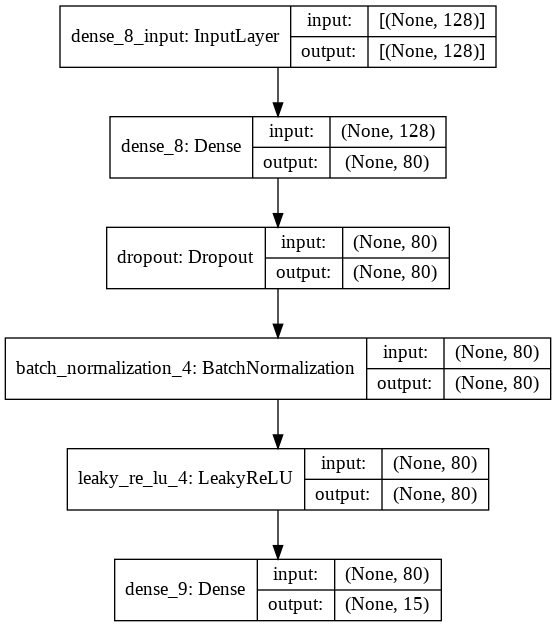

In [ ]:
# Define model with one hidden layer
def hidden_model4():
	# Create model
	model = Sequential(
    [      
      Dense(80, input_dim=num_samples),
      Dropout(0.2),
      BatchNormalization(),
      LeakyReLU(),
      Dense(num_tech, activation='softmax'),
    ]
  )
  # Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

h4_model = hidden_model4()
plot_model(h4_model, show_shapes=True)

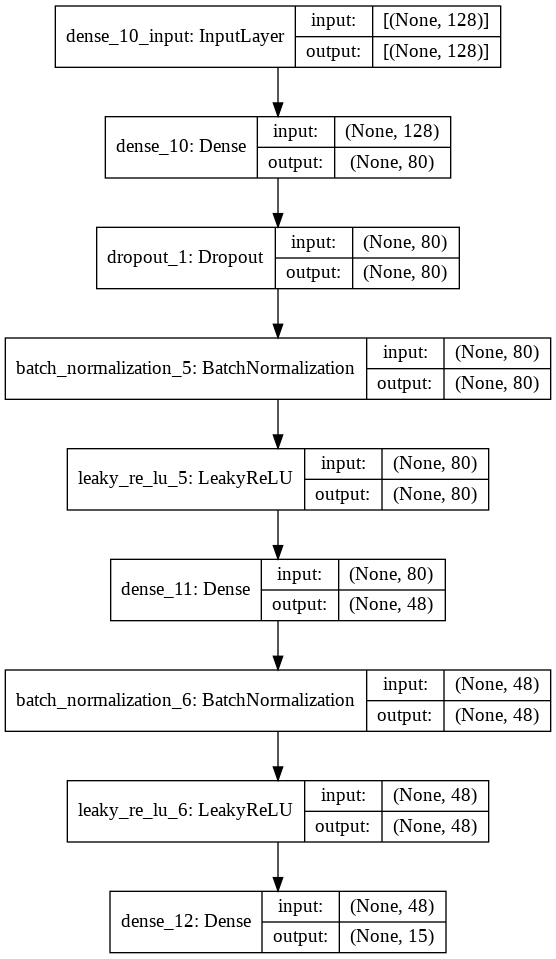

In [ ]:
# Define model with two hidden layers
def hidden_model5():
	# Create model
	model = Sequential(
    [      
      Dense(80, input_dim=num_samples),
      Dropout(0.2),
      BatchNormalization(),
      LeakyReLU(),
      Dense(48),
      BatchNormalization(),
      LeakyReLU(),
      Dense(num_tech, activation='softmax'),
    ]
  )
  # Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

h5_model = hidden_model5()
plot_model(h5_model, show_shapes=True)

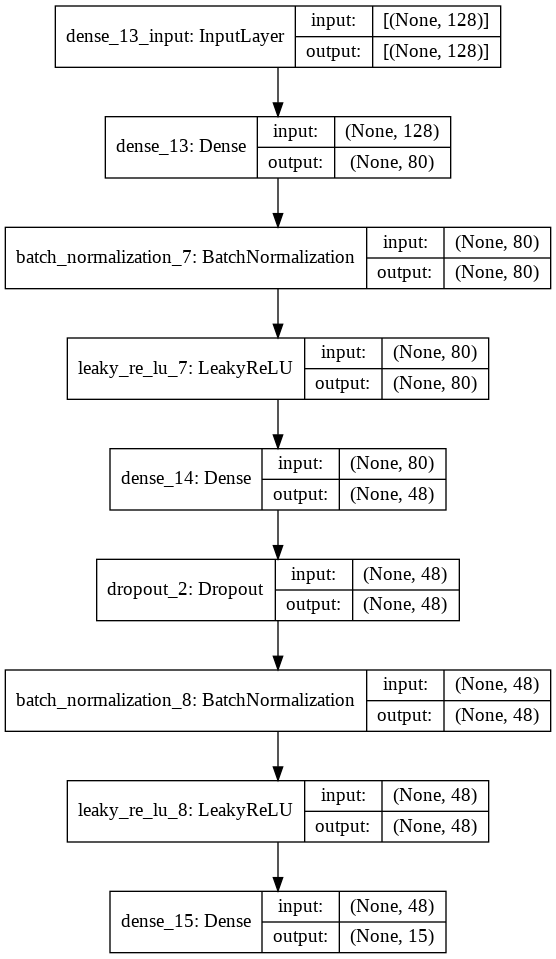

In [ ]:
# Define model with two hidden layers
def hidden_model6():
	# Create model
	model = Sequential(
    [      
      Dense(80, input_dim=num_samples),
      BatchNormalization(),
      LeakyReLU(),
      Dense(48),
      Dropout(0.2),
      BatchNormalization(),
      LeakyReLU(),
      Dense(num_tech, activation='softmax'),
    ]
  )
  # Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

h6_model = hidden_model6()
plot_model(h6_model, show_shapes=True)

In [ ]:
# Define model with two hidden layers
def hidden_model7():
	# Create model
	model = Sequential(
    [      
      Dense(80, input_dim=num_samples),
      BatchNormalization(),
      Dropout(0.2),
      LeakyReLU(),
      Dense(48),
      Dropout(0.2),
      BatchNormalization(),
      LeakyReLU(),
      Dense(num_tech, activation='softmax'),
    ]
  )
  # Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

h7_model = hidden_model7()
plot_model(h7_model, show_shapes=True)

NameError: ignored

We build an array based on these models for autoNN search.

In [ ]:
all_models = []
all_models.append(h1_model)
all_models.append(h2_model)
all_models.append(h3_model)
all_models.append(h4_model)
all_models.append(h5_model)
all_models.append(h6_model)
all_models.append(h7_model)

In [ ]:
from keras.callbacks import EarlyStopping

ES = EarlyStopping(monitor = 'val_accuracy', mode = 'max', min_delta = 0.000001, patience = 200, verbose = 1)

In [ ]:
scores_hidden_automl = np.zeros(7)
for i in range(7):
  all_models[i].fit(X_train[1], Y_train[1], validation_data = (X_test[1], Y_test[1]), epochs=500, batch_size=50, verbose=2, callbacks=[ES])
  all_models[i].save('hidden ' + str(i) + '.tf')
  score = all_models[i].evaluate(X_test[1], Y_test[1], verbose=0)
  scores_hidden_automl[i] = score[1]*100

Epoch 1/500
3379/3379 - 7s - loss: 0.5092 - accuracy: 0.8580 - val_loss: 0.4066 - val_accuracy: 0.8831
Epoch 2/500


KeyboardInterrupt: ignored

In [ ]:
for i in range(7):
  score = all_models[i].evaluate(X_test[1], Y_test[1], verbose=0)
  scores_hidden_automl[i] = score[1]*100

In [ ]:
scores_hidden_automl

array([88.53428364, 88.89836073, 88.99071217, 88.89836073, 89.12213445,
       88.93565536, 89.20382857])

Summarizing, we can see that the scores don't vary much but increase slightly with the addition of an additional hidden layer, more neurons and more dropout layers.

1. Baseline Model (No hidden layer but trained for 500 epochs)- 88.90%
2. One Hidden Layer with 60 neurons- 88.53%
3. One Hidden Layer with 80 neurons- 88.90%
4. Two Hidden Layers with 80 and 48 neurons- 88.99%
5. One Hidden Layer with 80 neurons & dropout- 88.90%
6. Two Hidden Layers with 80 and 48 neurons but dropout on first layer- 89.12%
7. Two Hidden Layers with 80 and 48 neurons but dropout on second layer- 88.94%
8. Two Hidden Layers with 80 and 48 neurons but dropout on both layers- 89.20%


## Convolutional Neural Network for FFT IQ and Phase/Mag Formats

As a bonus, I also try the CNN2 architecture in "O’Shea T.J., Corgan J., Clancy T.C. (2016) Convolutional Radio Modulation Recognition Networks. In: Jayne C., Iliadis L. (eds) Engineering Applications of Neural Networks. EANN 2016. Communications in Computer and Information Science, vol 629. Springer, Cham." that has worked very well for modulation types like QAM, QPSK etc. to the wireless technologies in the FFT IQ and Phase/Mag forms.



In [ ]:
# Define CNN2 with two hidden layers
def cnn2_model():
	# Create model
	model = Sequential(
    [      
      Conv2D(256, kernel_size = (3, 1), padding = "same", input_shape = (num_samples, 2, 1)),
      Dropout(0.6),
      BatchNormalization(),
      LeakyReLU(),
      Conv2D(80, kernel_size = (3, 2), padding = "same"),
      Dropout(0.6),
      BatchNormalization(),
      LeakyReLU(),
      Flatten(),
      Dense(10240),
      Dropout(0.6),
      BatchNormalization(),
      LeakyReLU(),
      Dense(256),
      BatchNormalization(),
      LeakyReLU(),
      Dense(num_tech, activation='softmax'),
    ]
  )
  # Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model

In [ ]:
fft_data_2d.shape

(225225, 128, 2)

In [ ]:
fft_data_iq = fft_data_2d.reshape(-1, num_samples, 2, 1)

In [ ]:
fft_data_iq.shape

(225225, 128, 2, 1)

In [ ]:
fft_iq_train, fft_iq_test, Y_iq_train, Y_iq_test = train_test_split(fft_data_iq, y_labels_one_hot, test_size=0.25)

In [ ]:
conv_model_fft_iq = cnn2_model()
conv_model_fft_iq.fit(fft_iq_train, Y_iq_train, validation_data = (fft_iq_test, Y_iq_test), epochs=2000, batch_size=1024, verbose=2, callbacks=[ES])
conv_model_fft_iq.save('conv iq.tf')
score = conv_model_fft_iq.evaluate(fft_iq_test, Y_iq_test, verbose=0)
scores_conv_fft_iq = score[1]*100

Epoch 1/2000


KeyboardInterrupt: ignored

In [ ]:
fft_data_phase_mag_2d = np.stack((fft_data_abs, fft_data_angle), axis =2)

In [ ]:
fft_data_phase_mag = fft_data_phase_mag_2d.reshape(-1, num_samples, 2, 1)

In [ ]:
fft_data_phase_mag.shape

(225225, 128, 2, 1)

In [ ]:
fft_phase_mag_train, fft_phase_mag_test, Y_phase_mag_train, Y_phase_mag_test = train_test_split(fft_data_phase_mag, y_labels_one_hot, test_size=0.25)

In [ ]:
conv_model_fft_phase_mag = cnn2_model()
conv_model_fft_phase_mag.fit(fft_phase_mag_train, Y_phase_mag_train, validation_data = (fft_phase_mag_test, Y_phase_mag_test), epochs=2000, batch_size=1024, verbose=2, callbacks=[ES])
conv_model_fft_phase_mag.save('conv phase_mag.tf')
score = conv_model_fft_phase_mag.evaluate(fft_phase_mag_test, Y_phase_mag_test, verbose=0)
scores_conv_phase_mag = score[1]*100

ResourceExhaustedError: ignored

The accuracy with the convolutional neural network CNN2 is as below after training typically.

1. FFT IQ data in 2D form- 92.56%
2. FFT Phase/Angle data in 2D form- 90.29%

With better tuning and training for larger number of epochs, an accuracy of >95% can be achieved.

In [ ]:
conv_model_fft_iq_final = cnn2_model()
conv_model_fft_iq_final.fit(fft_iq_train, Y_iq_train, validation_data = (fft_iq_test, Y_iq_test), epochs=1000, batch_size=50, verbose=2)
conv_model_fft_iq_final.save('conv iq.tf')
score = conv_model_fft_iq_final.evaluate(fft_iq_test, Y_iq_test, verbose=0)
scores_conv_fft_iq_final = score[1]*100

Epoch 1/1000
3379/3379 - 114s - loss: 0.4798 - accuracy: 0.8553 - val_loss: 0.4741 - val_accuracy: 0.8525
Epoch 2/1000


KeyboardInterrupt: ignored